# Canadian Housing Market Analysis
## CPSC 4310 - Data Analytics Project

**Team:** Project Group A  
**Student:** Chloe Lee (EDA & Modeling)  
**Date:** February 2026

---

## Project Overview

This notebook performs exploratory data analysis on Canadian housing prices across 5 major cities (2005–2025), engineers predictive features, and saves a clean dataset for modeling.

**Datasets:**
- `01_Data/Monthly Home Price and Index by type and city(in).csv` — MLS Home Price Index
- `01_Data/Daily Rates(in).csv` — Bank of Canada interest rates

---
# Part 1: Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


In [2]:
# Load datasets
print("Loading datasets...")

housing = pd.read_csv('../01_Data/Monthly Home Price and Index by type and city(in).csv')
rates   = pd.read_csv('../01_Data/Daily Rates(in).csv')

print(f"✓ Housing data loaded : {housing.shape[0]:,} rows × {housing.shape[1]} columns")
print(f"✓ Rates data loaded   : {rates.shape[0]:,} rows × {rates.shape[1]} columns")

Loading datasets...
✓ Housing data loaded : 7,560 rows × 5 columns
✓ Rates data loaded   : 7,670 rows × 6 columns


In [3]:
print("=" * 80)
print("HOUSING DATA PREVIEW")
print("=" * 80)
display(housing.head())
print(f"\nColumns    : {housing.columns.tolist()}")
print(f"Cities     : {housing['City'].unique().tolist()}")
print(f"House Types: {housing['House_Type'].unique().tolist()}")
print(f"Date Range : {housing['Date'].min()} → {housing['Date'].max()}")

print()
print("=" * 80)
print("INTEREST RATE DATA PREVIEW")
print("=" * 80)
display(rates.head())
print(f"\nColumns   : {rates.columns.tolist()}")
print(f"Date Range: {rates['Date'].min()} → {rates['Date'].max()}")

HOUSING DATA PREVIEW


,Date,City,House_Type,Price,Index
0,2005-01-01,Greater Vancouver,Composite,349600,100.00
1,2005-02-01,Greater Vancouver,Composite,353000,101.00
2,2005-03-01,Greater Vancouver,Composite,357400,102.20
3,2005-04-01,Greater Vancouver,Composite,360500,103.10
4,2005-05-01,Greater Vancouver,Composite,364000,104.10



Columns    : ['Date', 'City', 'House_Type', 'Price', 'Index']
Cities     : ['Greater Vancouver', 'Calgary', 'Ottawa', 'Greater Toronto', 'Montreal CMA']
House Types: ['Composite', 'Single_Family', 'One_Storey', 'Two_Storey', 'Townhouse', 'Apartment']
Date Range : 2005-01-01 → 2025-12-01

INTEREST RATE DATA PREVIEW


,Date,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate,Policy_Rate
0,2005-01-01,4.25,4.80,5.60,6.05,NaN
1,2005-01-02,4.25,4.80,5.60,6.05,NaN
2,2005-01-03,4.25,4.80,5.60,6.05,NaN
3,2005-01-04,4.25,4.80,5.60,6.05,NaN
4,2005-01-05,4.25,4.80,5.60,6.05,NaN



Columns   : ['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate', 'Policy_Rate']
Date Range: 2005-01-01 → 2025-12-31


---
# Part 2: Data Preprocessing and Integration

In [4]:
# Step 1: Convert dates
print("[1/6] Converting date formats...")
housing['Date'] = pd.to_datetime(housing['Date'])
rates['Date']   = pd.to_datetime(rates['Date'])
print(f"  ✓ Housing: {housing['Date'].min().date()} → {housing['Date'].max().date()}")
print(f"  ✓ Rates  : {rates['Date'].min().date()} → {rates['Date'].max().date()}")

[1/6] Converting date formats...
  ✓ Housing: 2005-01-01 → 2025-12-01
  ✓ Rates  : 2005-01-01 → 2025-12-31


In [5]:
# Step 2: Filter to Composite house type only
print("[2/6] Filtering to Composite house type...")

housing_composite = housing[housing['House_Type'] == 'Composite'].copy()
housing_composite = housing_composite.drop(columns=['House_Type'])

print(f"  ✓ Before: {len(housing)} rows (all house types)")
print(f"  ✓ After : {len(housing_composite)} rows (Composite only)")
print(f"  ✓ Cities: {housing_composite['City'].unique().tolist()}")

[2/6] Filtering to Composite house type...
  ✓ Before: 7560 rows (all house types)
  ✓ After : 1260 rows (Composite only)
  ✓ Cities: ['Greater Vancouver', 'Calgary', 'Ottawa', 'Greater Toronto', 'Montreal CMA']


In [6]:
# Step 3: Convert daily rates to monthly averages
print("[3/6] Converting daily rates to monthly averages...")

# Forward-fill Policy_Rate (announced only 8x/year)
rates['Policy_Rate'] = rates['Policy_Rate'].ffill().bfill()

rates['YearMonth'] = rates['Date'].dt.to_period('M')
rates_monthly = rates.groupby('YearMonth').agg({
    'Mortgage_1Y': 'mean',
    'Mortgage_3Y': 'mean',
    'Mortgage_5Y': 'mean',
    'Prime_Rate' : 'mean',
    'Policy_Rate': 'last'
}).reset_index()
rates_monthly['Date'] = rates_monthly['YearMonth'].dt.to_timestamp()
rates_monthly = rates_monthly.drop(columns=['YearMonth'])

print(f"  ✓ Monthly rates: {len(rates_monthly)} rows")
display(rates_monthly.head(3))

[3/6] Converting daily rates to monthly averages...
  ✓ Monthly rates: 252 rows


,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate,Policy_Rate,Date
0,4.25,4.80,5.60,6.05,0.50,2005-01-01
1,4.25,4.80,5.60,6.05,0.50,2005-02-01
2,4.25,4.82,5.62,6.06,0.50,2005-03-01


In [7]:
# Step 4: Merge housing and rates
print("[4/6] Merging housing and rates data...")

df = housing_composite.merge(rates_monthly, on='Date', how='left')

print(f"  ✓ Merged dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"  ✓ Columns: {df.columns.tolist()}")

[4/6] Merging housing and rates data...
  ✓ Merged dataset: 1260 rows × 9 columns
  ✓ Columns: ['Date', 'City', 'Price', 'Index', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate', 'Policy_Rate']


In [8]:
# Step 5: Check missing values
print("[5/6] Checking for missing values...")

missing = df.isnull().sum()
missing = missing[missing > 0]

if len(missing) == 0:
    print("  ✓ No missing values found!")
else:
    print("  Missing values:")
    for col, count in missing.items():
        pct = count / len(df) * 100
        print(f"    {col:25}: {count} ({pct:.1f}%)")

[5/6] Checking for missing values...
  ✓ No missing values found!


In [9]:
# Step 6: Sort by City and Date
print("[6/6] Sorting data...")

df = df.sort_values(['City', 'Date']).reset_index(drop=True)

print("  ✓ Data sorted by City and Date")
print("=" * 80)
print("DATA PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"  Final dataset: {len(df)} rows × {len(df.columns)} columns")
print(f"  Cities: {df['City'].nunique()}")
print(f"  Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
display(df.head(10))

[6/6] Sorting data...
  ✓ Data sorted by City and Date
DATA PREPROCESSING COMPLETE!
  Final dataset: 1260 rows × 9 columns
  Cities: 5
  Date range: 2005-01-01 → 2025-12-01


,Date,City,Price,Index,Mortgage_1Y,Mortgage_3Y,Mortgage_5Y,Prime_Rate,Policy_Rate
0,2005-01-01,Calgary,207400,100.00,4.25,4.80,5.60,6.05,0.50
1,2005-02-01,Calgary,210100,101.30,4.25,4.80,5.60,6.05,0.50
2,2005-03-01,Calgary,214000,103.20,4.25,4.82,5.62,6.06,0.50
3,2005-04-01,Calgary,217200,104.70,4.25,5.00,5.76,6.18,0.50
4,2005-05-01,Calgary,219400,105.80,4.25,4.89,5.60,6.03,0.50
5,2005-06-01,Calgary,220900,106.50,4.25,4.77,5.38,5.74,0.50
6,2005-07-01,Calgary,223500,107.80,4.25,4.81,5.37,5.74,0.50
7,2005-08-01,Calgary,225700,108.80,4.25,4.95,5.42,5.82,0.50
8,2005-09-01,Calgary,228400,110.10,4.39,5.00,5.40,5.80,0.50
9,2005-10-01,Calgary,231500,111.60,4.60,5.08,5.48,5.91,0.50


---
# Part 3: Feature Engineering

We create four types of features:
1. **Lag Features** — Past Index values (1, 3, 12 months ago)
2. **Change Features** — Month-over-Month and Year-over-Year % changes
3. **Rolling Averages** — Smoothed trends (3-month, 12-month)
4. **Time Features** — Month, Quarter, Year
5. **Derived Features** — Distance from moving average, trend difference

In [10]:
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)
print(f"\nStarting with: {len(df)} rows × {len(df.columns)} columns")

FEATURE ENGINEERING

Starting with: 1260 rows × 9 columns


In [11]:
# 1. Lag Features — per city (critical: group by City!)
print("\n[1/5] Creating Lag Features...")

df = df.sort_values(['City', 'Date']).reset_index(drop=True)

df['Index_Lag1']  = df.groupby('City')['Index'].shift(1)
df['Index_Lag3']  = df.groupby('City')['Index'].shift(3)
df['Index_Lag12'] = df.groupby('City')['Index'].shift(12)

print("  ✓ Created: Index_Lag1, Index_Lag3, Index_Lag12")


[1/5] Creating Lag Features...
  ✓ Created: Index_Lag1, Index_Lag3, Index_Lag12


In [12]:
# 2. Change Features
print("\n[2/5] Creating Change Features...")

df['Index_MoM_Change']   = df.groupby('City')['Index'].pct_change(1)  * 100
df['Index_YoY_Change']   = df.groupby('City')['Index'].pct_change(12) * 100
df['Mortgage_5Y_Change'] = df['Mortgage_5Y'].pct_change(1) * 100

print("  ✓ Created: Index_MoM_Change, Index_YoY_Change, Mortgage_5Y_Change")


[2/5] Creating Change Features...
  ✓ Created: Index_MoM_Change, Index_YoY_Change, Mortgage_5Y_Change


In [13]:
# 3. Rolling Averages — per city
print("\n[3/5] Creating Rolling Averages...")

df['Index_MA3']  = df.groupby('City')['Index'].transform(
    lambda x: x.rolling(window=3,  min_periods=1).mean())
df['Index_MA12'] = df.groupby('City')['Index'].transform(
    lambda x: x.rolling(window=12, min_periods=1).mean())

print("  ✓ Created: Index_MA3, Index_MA12")


[3/5] Creating Rolling Averages...
  ✓ Created: Index_MA3, Index_MA12


In [14]:
# 4. Time Features
print("\n[4/5] Creating Time Features...")

df['Month']   = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year']    = df['Date'].dt.year

print("  ✓ Created: Month, Quarter, Year")


[4/5] Creating Time Features...
  ✓ Created: Month, Quarter, Year


In [15]:
# 5. Derived Features
print("\n[5/5] Creating Derived Features...")

df['Price_Above_MA3'] = df['Index'] - df['Index_MA3']
df['MA3_MA12_Diff']   = df['Index_MA3'] - df['Index_MA12']

print("  ✓ Created: Price_Above_MA3, MA3_MA12_Diff")


[5/5] Creating Derived Features...
  ✓ Created: Price_Above_MA3, MA3_MA12_Diff


In [16]:
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 80)
print(f"Total columns: {len(df.columns)}")

new_features = [
    'Index_Lag1', 'Index_Lag3', 'Index_Lag12',
    'Index_MoM_Change', 'Index_YoY_Change', 'Mortgage_5Y_Change',
    'Index_MA3', 'Index_MA12',
    'Month', 'Quarter', 'Year',
    'Price_Above_MA3', 'MA3_MA12_Diff'
]

print("\nNew features created:")
for f in new_features:
    missing_count = df[f].isnull().sum()
    print(f"  ✓ {f:25} ({missing_count} missing — expected for lag start)")

print(f"\nDataset shape: {df.shape}")


FEATURE ENGINEERING COMPLETE!
Total columns: 22

New features created:
  ✓ Index_Lag1                (5 missing — expected for lag start)
  ✓ Index_Lag3                (15 missing — expected for lag start)
  ✓ Index_Lag12               (60 missing — expected for lag start)
  ✓ Index_MoM_Change          (5 missing — expected for lag start)
  ✓ Index_YoY_Change          (60 missing — expected for lag start)
  ✓ Mortgage_5Y_Change        (1 missing — expected for lag start)
  ✓ Index_MA3                 (0 missing — expected for lag start)
  ✓ Index_MA12                (0 missing — expected for lag start)
  ✓ Month                     (0 missing — expected for lag start)
  ✓ Quarter                   (0 missing — expected for lag start)
  ✓ Year                      (0 missing — expected for lag start)
  ✓ Price_Above_MA3           (0 missing — expected for lag start)
  ✓ MA3_MA12_Diff             (0 missing — expected for lag start)

Dataset shape: (1260, 22)


---
# Part 4: Exploratory Data Analysis (EDA)

Six visualizations covering price trends, interest rates, correlations, and city comparisons.

Creating visualization 1: Housing Price Trends by City...


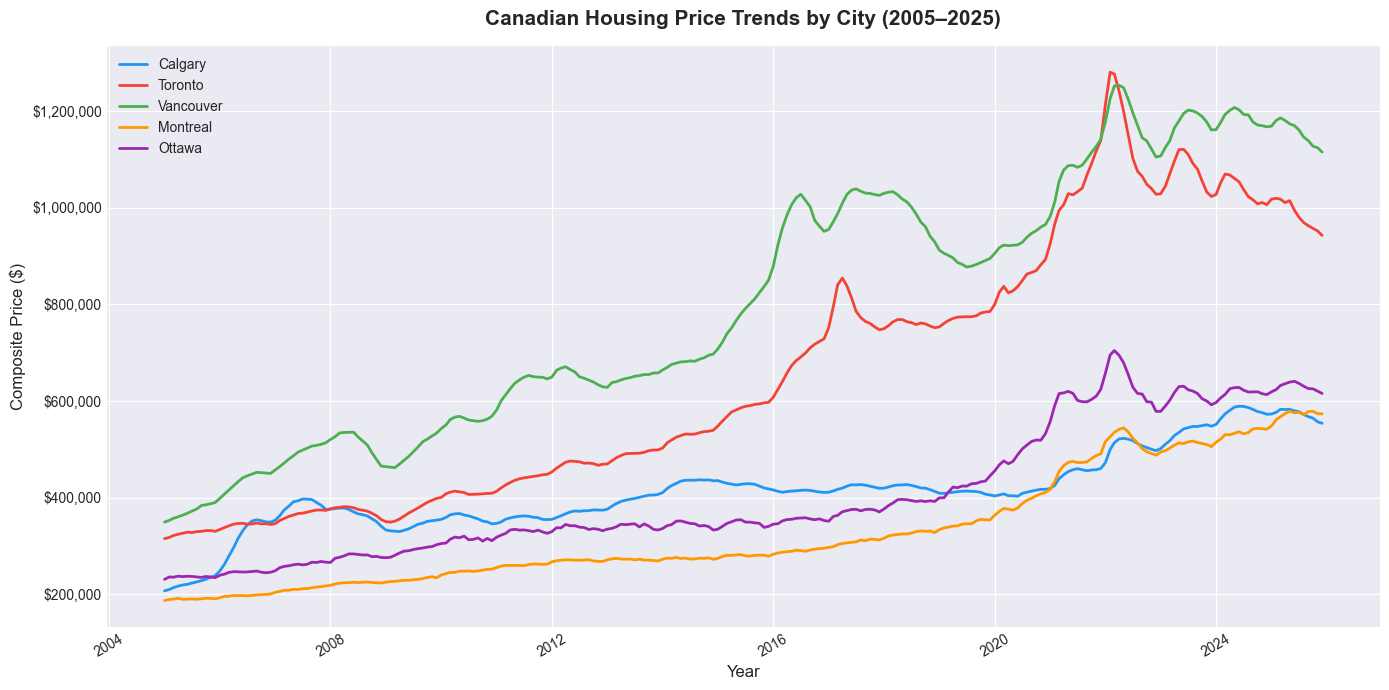

  ✓ Saved: 1_price_trends.png


In [17]:
# EDA 1: Housing Price Trends by City
print("Creating visualization 1: Housing Price Trends by City...")

cities = df['City'].unique()
colors = ['#2196F3', '#F44336', '#4CAF50', '#FF9800', '#9C27B0']

fig, ax = plt.subplots(figsize=(14, 7))

for i, city in enumerate(cities):
    city_data = df[df['City'] == city].sort_values('Date')
    label = city.replace('Greater ', '').replace(' CMA', '')
    ax.plot(city_data['Date'], city_data['Price'],
            label=label, color=colors[i], linewidth=2)

ax.set_title('Canadian Housing Price Trends by City (2005–2025)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Composite Price ($)', fontsize=12)
ax.legend(fontsize=10, loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../03_Results/visualization/1_price_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 1_price_trends.png")

In [18]:
# Statistics by city
print("\nEDA 1: Price Statistics by City")
print("=" * 70)

stats = df.groupby('City')['Price'].agg(['min', 'max', 'mean']).round(0)
stats.columns = ['Min ($)', 'Max ($)', 'Mean ($)']

# Growth since 2005
for city in df['City'].unique():
    city_df = df[df['City'] == city].sort_values('Date')
    start = city_df['Price'].iloc[0]
    end   = city_df['Price'].iloc[-1]
    growth = (end / start - 1) * 100
    stats.loc[city, 'Growth (%)'] = round(growth, 1)

print(stats.to_string())


EDA 1: Price Statistics by City
                   Min ($)  Max ($)  Mean ($)  Growth (%)
City                                                     
Calgary             207400   589100 413810.00      167.10
Greater Toronto     315300  1279800 657896.00      198.90
Greater Vancouver   349600  1252800 802119.00      218.90
Montreal CMA        187300   578900 329126.00      206.10
Ottawa              231100   704400 402662.00      166.30


Creating visualization 2: Interest Rate Trends...


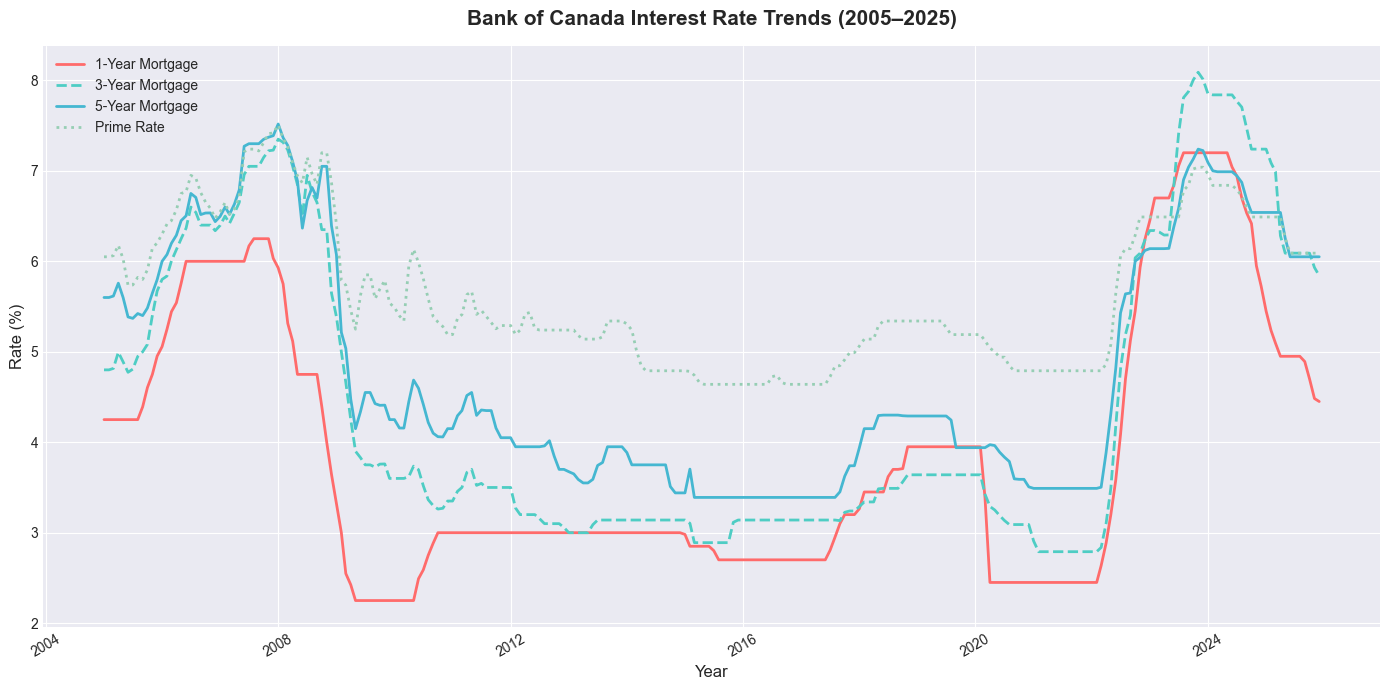

  ✓ Saved: 2_interest_rates.png


In [19]:
# EDA 2: Interest Rate Trends
print("Creating visualization 2: Interest Rate Trends...")

rates_plot = df[['Date', 'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate']
               ].drop_duplicates('Date').sort_values('Date')

fig, ax = plt.subplots(figsize=(14, 7))

rate_styles = {
    'Mortgage_1Y': ('#FF6B6B', '-',  '1-Year Mortgage'),
    'Mortgage_3Y': ('#4ECDC4', '--', '3-Year Mortgage'),
    'Mortgage_5Y': ('#45B7D1', '-',  '5-Year Mortgage'),
    'Prime_Rate' : ('#96CEB4', ':',  'Prime Rate'),
}

for col, (color, ls, label) in rate_styles.items():
    ax.plot(rates_plot['Date'], rates_plot[col],
            label=label, color=color, linestyle=ls, linewidth=2)

ax.set_title('Bank of Canada Interest Rate Trends (2005–2025)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.legend(fontsize=10)
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../03_Results/visualization/2_interest_rates.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 2_interest_rates.png")

Creating visualization 3: Price vs Interest Rate (Vancouver)...


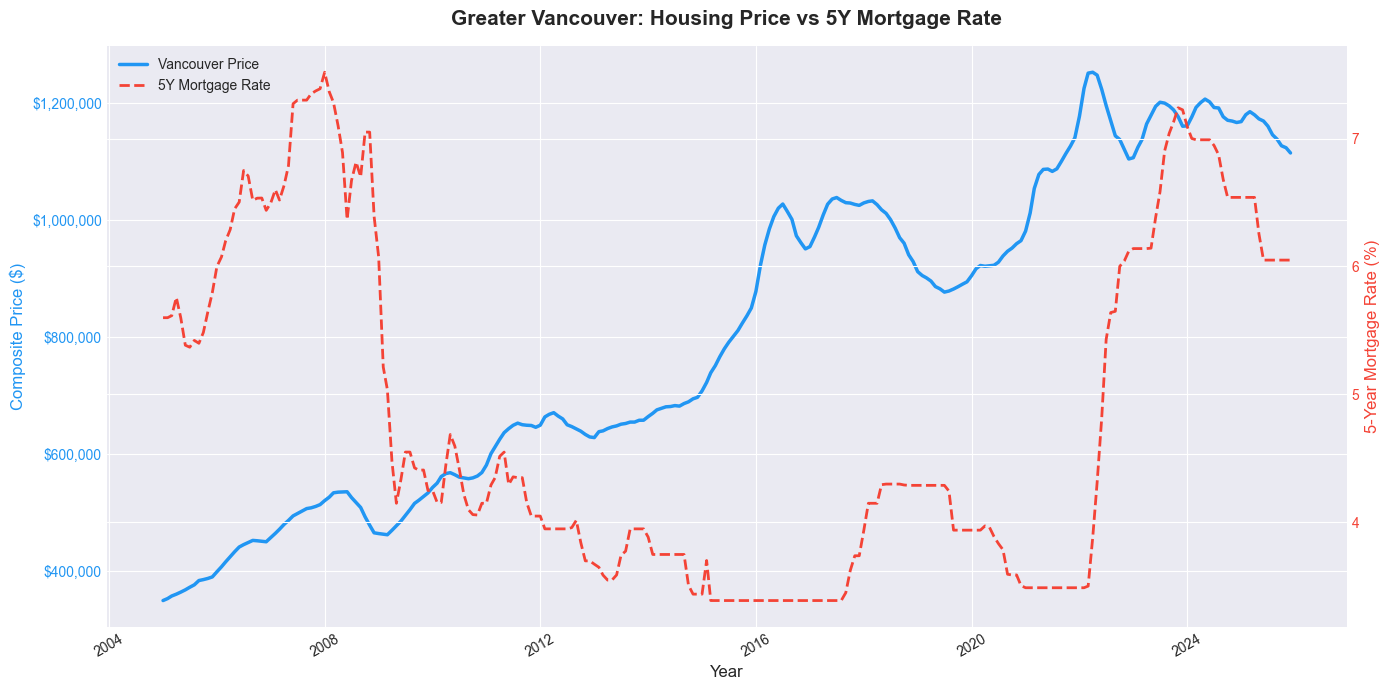

  ✓ Saved: 3_dual_axis_vancouver.png


In [20]:
# EDA 3: Dual-Axis Chart — Vancouver Price vs 5Y Mortgage Rate
print("Creating visualization 3: Price vs Interest Rate (Vancouver)...")

van = df[df['City'] == 'Greater Vancouver'].sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = '#2196F3'
ax1.plot(van['Date'], van['Price'], color=color1, linewidth=2.5, label='Vancouver Price')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Composite Price ($)', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

ax2 = ax1.twinx()
color2 = '#F44336'
ax2.plot(van['Date'], van['Mortgage_5Y'], color=color2, linewidth=2,
         linestyle='--', label='5Y Mortgage Rate')
ax2.set_ylabel('5-Year Mortgage Rate (%)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='upper left')

ax1.set_title('Greater Vancouver: Housing Price vs 5Y Mortgage Rate',
              fontsize=15, fontweight='bold', pad=15)
ax1.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../03_Results/visualization/3_dual_axis_vancouver.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 3_dual_axis_vancouver.png")

Creating visualization 4: Correlation Heatmap...


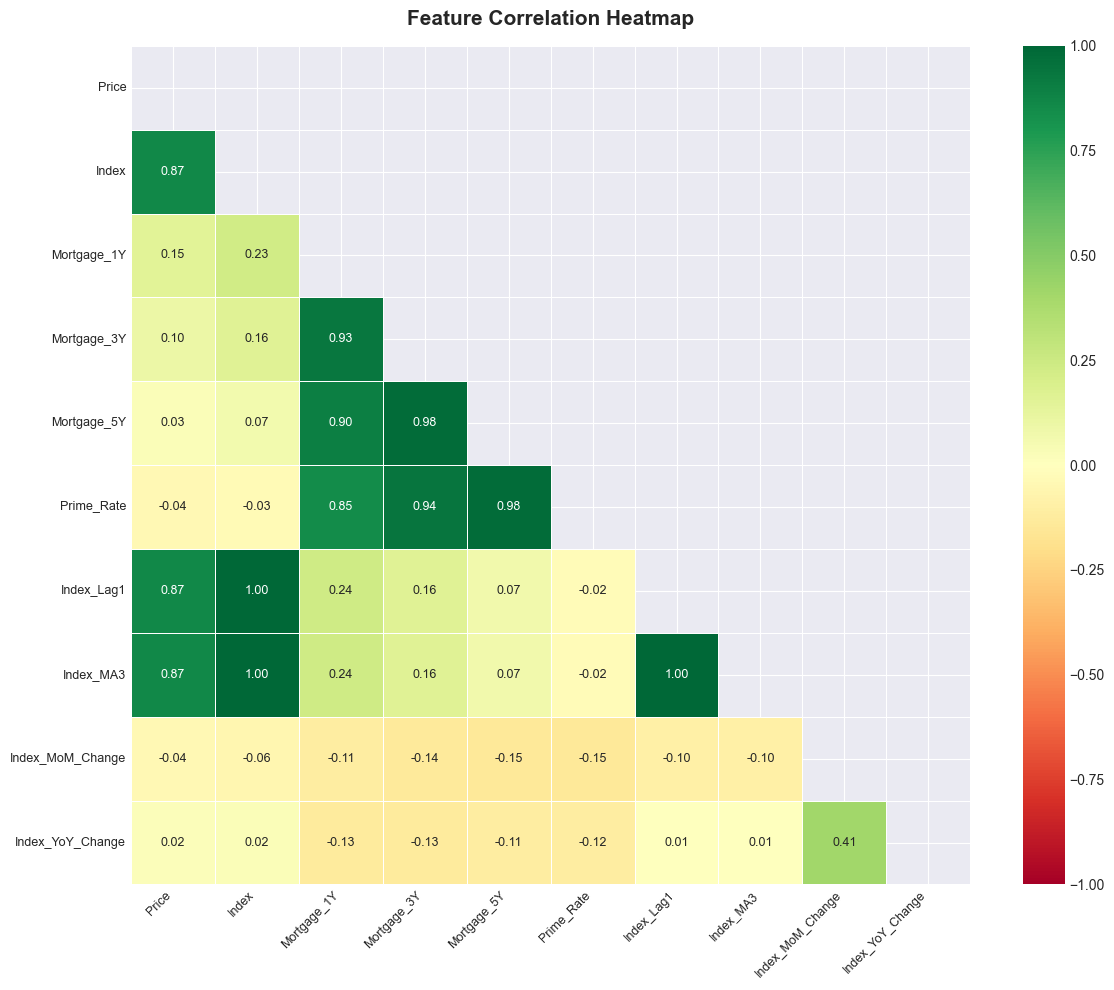

  ✓ Saved: 4_correlation_heatmap.png


In [21]:
# EDA 4: Correlation Heatmap
print("Creating visualization 4: Correlation Heatmap...")

numeric_features = [
    'Price', 'Index',
    'Mortgage_1Y', 'Mortgage_3Y', 'Mortgage_5Y', 'Prime_Rate',
    'Index_Lag1', 'Index_MA3', 'Index_MoM_Change', 'Index_YoY_Change'
]

corr_data = df[numeric_features].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, vmin=-1, vmax=1,
            annot_kws={'size': 9},
            linewidths=0.5)

plt.title('Feature Correlation Heatmap', fontsize=15, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.savefig('../03_Results/visualization/4_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 4_correlation_heatmap.png")

In [22]:
# Top correlations with Index
print("\nTop Correlations with Index:")
print("=" * 50)

index_corr = correlation_matrix['Index'].drop('Index').sort_values(ascending=False)
for feature, corr in index_corr.items():
    bar = '█' * int(abs(corr) * 20)
    direction = '+' if corr > 0 else '-'
    print(f"  {feature:25} : {corr:+.3f}  {direction}{bar}")


Top Correlations with Index:
  Index_MA3                 : +0.999  +███████████████████
  Index_Lag1                : +0.999  +███████████████████
  Price                     : +0.866  +█████████████████
  Mortgage_1Y               : +0.232  +████
  Mortgage_3Y               : +0.157  +███
  Mortgage_5Y               : +0.066  +█
  Index_YoY_Change          : +0.025  +
  Prime_Rate                : -0.033  -
  Index_MoM_Change          : -0.058  -█


Creating visualization 5: Price Distribution by City...


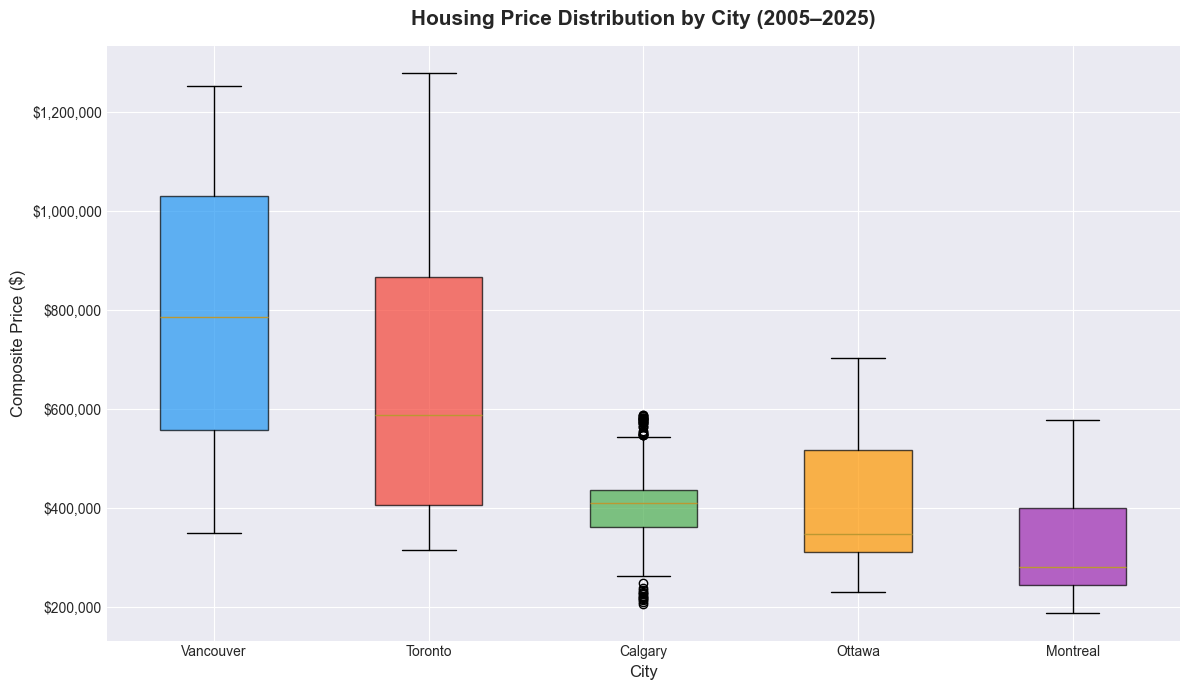

  ✓ Saved: 5_boxplot_by_city.png


In [23]:
# EDA 5: Box Plot — Price Distribution by City
print("Creating visualization 5: Price Distribution by City...")

cities_short = {
    'Greater Vancouver': 'Vancouver',
    'Greater Toronto'  : 'Toronto',
    'Calgary'          : 'Calgary',
    'Ottawa'           : 'Ottawa',
    'Montreal CMA'     : 'Montreal'
}

df_plot = df.copy()
df_plot['City_Short'] = df_plot['City'].map(cities_short)

fig, ax = plt.subplots(figsize=(12, 7))

city_order = (df_plot.groupby('City_Short')['Price']
              .median().sort_values(ascending=False).index)

data_by_city = [df_plot[df_plot['City_Short'] == c]['Price'].values
                for c in city_order]

bp = ax.boxplot(data_by_city, labels=city_order,
                patch_artist=True, notch=False)

colors_box = ['#2196F3', '#F44336', '#4CAF50', '#FF9800', '#9C27B0']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Housing Price Distribution by City (2005–2025)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Composite Price ($)', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.savefig('../03_Results/visualization/5_boxplot_by_city.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 5_boxplot_by_city.png")

In [24]:
# Volatility ranking
print("\nPrice Volatility by City (Std Dev):")
print("=" * 50)

volatility = (df.groupby('City')['Price'].std()
              .rename(lambda x: cities_short.get(x, x))
              .sort_values(ascending=False))

for city, std in volatility.items():
    bar = '█' * int(std / 5000)
    print(f"  {city:12}: ${std:,.0f}  {bar}")


Price Volatility by City (Std Dev):
  Toronto     : $272,374  ██████████████████████████████████████████████████████
  Vancouver   : $270,211  ██████████████████████████████████████████████████████
  Ottawa      : $135,206  ███████████████████████████
  Montreal    : $117,524  ███████████████████████
  Calgary     : $82,683  ████████████████


Creating visualization 6: Year-over-Year Change Trends...


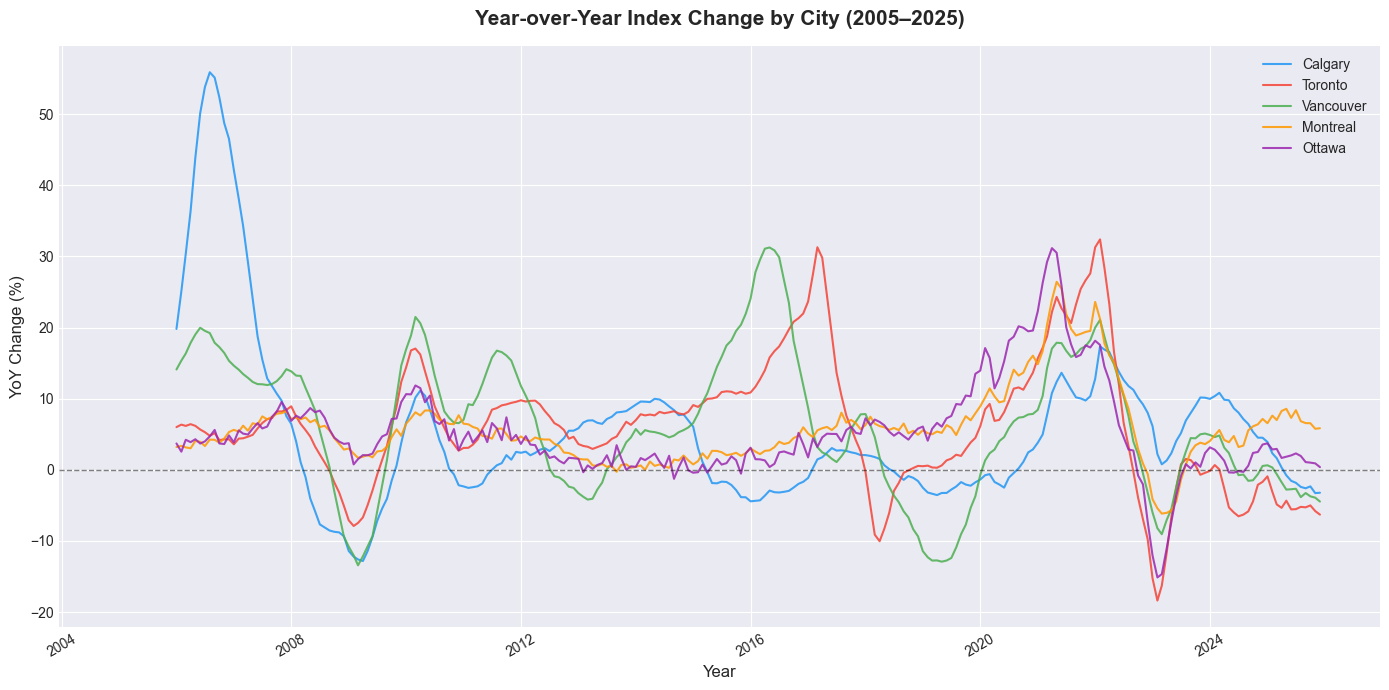

  ✓ Saved: 6_yoy_trends.png


In [25]:
# EDA 6: Year-over-Year Change Trends by City
print("Creating visualization 6: Year-over-Year Change Trends...")

fig, ax = plt.subplots(figsize=(14, 7))

for i, city in enumerate(cities):
    city_data = df[df['City'] == city].sort_values('Date').dropna(subset=['Index_YoY_Change'])
    label = city.replace('Greater ', '').replace(' CMA', '')
    ax.plot(city_data['Date'], city_data['Index_YoY_Change'],
            label=label, color=colors[i], linewidth=1.5, alpha=0.85)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(df['Date'].drop_duplicates().sort_values(),
                0, 0, alpha=0)  # just for reference

ax.set_title('Year-over-Year Index Change by City (2005–2025)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.legend(fontsize=10)
ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.savefig('../03_Results/visualization/6_yoy_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print("  ✓ Saved: 6_yoy_trends.png")

In [26]:
# Peak growth periods
print("\nPeak YoY Growth by City:")
print("=" * 60)

for city in df['City'].unique():
    city_df = df[df['City'] == city].dropna(subset=['Index_YoY_Change'])
    peak_row = city_df.loc[city_df['Index_YoY_Change'].idxmax()]
    label = city.replace('Greater ', '').replace(' CMA', '')
    print(f"  {label:12}: +{peak_row['Index_YoY_Change']:.1f}%  ({peak_row['Date'].strftime('%Y-%m')})")


Peak YoY Growth by City:
  Calgary     : +55.9%  (2006-08)
  Toronto     : +32.4%  (2022-02)
  Vancouver   : +31.2%  (2016-05)
  Montreal    : +26.4%  (2021-05)
  Ottawa      : +31.2%  (2021-04)


---
# Part 5: Key Findings Summary

In [27]:
print("=" * 80)
print("KEY FINDINGS FROM EDA")
print("=" * 80)

print("\n1. HOUSING PRICE GROWTH (2005-2025):")
for city in df['City'].unique():
    city_df = df[df['City'] == city].sort_values('Date')
    start  = city_df['Price'].iloc[0]
    end    = city_df['Price'].iloc[-1]
    growth = (end / start - 1) * 100
    label  = city.replace('Greater ', '').replace(' CMA', '')
    print(f"   {label:12}: ${start:,.0f} → ${end:,.0f}  (+{growth:.1f}%)")

print("\n2. INTEREST RATE OBSERVATIONS:")
print(f"   Peak 5Y Mortgage : {df['Mortgage_5Y'].max():.2f}% ({df.loc[df['Mortgage_5Y'].idxmax(), 'Date'].strftime('%Y-%m')})")
print(f"   Low  5Y Mortgage : {df['Mortgage_5Y'].min():.2f}% ({df.loc[df['Mortgage_5Y'].idxmin(), 'Date'].strftime('%Y-%m')})")
print(f"   Current (latest) : {df['Mortgage_5Y'].iloc[-1]:.2f}%")

print("\n3. STRONGEST PREDICTORS (correlation with Index):")
top_corr = correlation_matrix['Index'].drop('Index').abs().sort_values(ascending=False).head(5)
for feat, corr in top_corr.items():
    print(f"   {feat:25}: {corr:.3f}")

KEY FINDINGS FROM EDA

1. HOUSING PRICE GROWTH (2005-2025):
   Calgary     : $207,400 → $553,900  (+167.1%)
   Toronto     : $315,300 → $942,300  (+198.9%)
   Vancouver   : $349,600 → $1,114,800  (+218.9%)
   Montreal    : $187,300 → $573,300  (+206.1%)
   Ottawa      : $231,100 → $615,500  (+166.3%)

2. INTEREST RATE OBSERVATIONS:
   Peak 5Y Mortgage : 7.52% (2008-01)
   Low  5Y Mortgage : 3.39% (2015-03)
   Current (latest) : 6.05%

3. STRONGEST PREDICTORS (correlation with Index):
   Index_MA3                : 0.999
   Index_Lag1               : 0.999
   Price                    : 0.866
   Mortgage_1Y              : 0.232
   Mortgage_3Y              : 0.157


---
# Part 6: Save Processed Data

In [28]:
# Save the processed dataset for modeling
output_file = '../03_Results/housing_data_with_features.csv'
df.to_csv(output_file, index=False)

print(f"✓ Processed data saved to: {output_file}")
print(f"  Rows    : {len(df)}")
print(f"  Columns : {len(df.columns)}")
print(f"\nColumn list:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")
print(f"\n✅ This file is ready for Baseline_Model.ipynb!")

✓ Processed data saved to: ../03_Results/housing_data_with_features.csv
  Rows    : 1260
  Columns : 22

Column list:
   1. Date
   2. City
   3. Price
   4. Index
   5. Mortgage_1Y
   6. Mortgage_3Y
   7. Mortgage_5Y
   8. Prime_Rate
   9. Policy_Rate
  10. Index_Lag1
  11. Index_Lag3
  12. Index_Lag12
  13. Index_MoM_Change
  14. Index_YoY_Change
  15. Mortgage_5Y_Change
  16. Index_MA3
  17. Index_MA12
  18. Month
  19. Quarter
  20. Year
  21. Price_Above_MA3
  22. MA3_MA12_Diff

✅ This file is ready for Baseline_Model.ipynb!


In [29]:
# Quick summary statistics
print("=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

summary = df.groupby('City').agg(
    Records=('Price', 'count'),
    Min_Price=('Price', 'min'),
    Max_Price=('Price', 'max'),
    Mean_Price=('Price', 'mean'),
    Std_Price=('Price', 'std')
).round(0)

print(summary.to_string())

# Save summary
summary.to_csv('../03_Results/summary_statistics.txt', sep='\t')
print("\n✓ Summary saved to 03_Results/summary_statistics.txt")

SUMMARY STATISTICS
                   Records  Min_Price  Max_Price  Mean_Price  Std_Price
City                                                                   
Calgary                252     207400     589100   413810.00   82683.00
Greater Toronto        252     315300    1279800   657896.00  272374.00
Greater Vancouver      252     349600    1252800   802119.00  270211.00
Montreal CMA           252     187300     578900   329126.00  117524.00
Ottawa                 252     231100     704400   402662.00  135206.00

✓ Summary saved to 03_Results/summary_statistics.txt


---
# Next Steps

## For Milestone 2 (Week 7):
1. ✅ EDA Complete (6 visualizations)
2. ⏭️ Build Baseline Model (Linear Regression) → `Baseline_Model.ipynb`
3. ⏭️ Evaluate Performance (RMSE, MAE, R², MAPE)

## For Milestone 3 (Week 11):
1. Advanced Models (Random Forest, XGBoost) → `Advanced_Models.ipynb`
2. Model Comparison
3. Dashboard → Vergil
4. Final Report → Ryan